<a href="https://colab.research.google.com/github/astrfo/RS_init/blob/main/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://colab.research.google.com/drive/199SxVBGDdkuzSzU9pjVP9BfMPzaypLfj#scrollTo=UUSaBpguVsBB




In [34]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
class Environment(object):

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])   #一様分布からサンプリング
        print(f'{self.prob}')

    def play(self, arm):
        if self.prob[arm] > random.random():
            return 1
        else:
            return 0

In [36]:
class Agent(object):

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.RS = None
        self.aleph = 1.0        #必ず非満足状態になるように

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([sys.float_info.min] * self._K)      #RS式でゼロ除算を防ぐため
        self._N = 0
        self.RS = np.zeros(self._K)     #RSの初期値はゼロ？？

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + self._alpha * reward
        self._n[arm] += 1
        self._N += 1
        self.RS[arm] = self._n[arm] / self._N * (self._V[arm] - self.aleph)     #RS評価値の更新(これは後で分ける？)

    def update_aleph(self):
        #2本腕を想定
        max_V = np.amax(self._V)
        # print(f'V: {self._V}')
        # print(f'maxV: {max_V}')
        mI = random.choice(np.where(self._V == max_V)[0])       #複数あった場合エラー吐く
        if mI == 0: nmI = 1     #このコードは直せ
        else: nmI = 0
        # nmI = random.choice(np.where(self._V != max_V)[0])
        upper = 1 - (self._V[nmI]/self._V[mI]) * (self._n[nmI]/self._n[mI])     #腕の確率が小さいと V(a_G) = V(a_j) = 0 でエラーになる可能性がある(一度も当たらない)
        under = (1 - self._n[nmI]/self._n[mI])
        self.aleph = max_V * upper / under
        print(f'n: {self._n}')
        print(f'V: {self._V}')
        print(f'upper: {upper}, under: {under}')
        print(f'aleph: {self.aleph}')

    def select_arm(self):
        maxRS = np.amax(self.RS)
        maxIndex = np.where(self.RS == maxRS)[0]
        # print(f'random.maxIndex: {random.choice(maxIndex)}')
        return random.choice(maxIndex)

In [37]:
class Simulator(object):
    
    def __init__(self, trial, step, K):
        self._agent = Agent(K)
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._regret = np.zeros((trial, step))

    def run(self):
        for t in range(self._trial):
            print(f'{t}:')
            self._env = Environment(K)
            self._prob = self._env.prob
            self._agent.initialize()
            for s in range(self._step):
                arm = self._agent.select_arm()
                reward = self._env.play(arm)
                self._agent.update(arm, reward)
                # print(f'arm: {arm}, reward: {reward}')
                self.calc_regret(t, s, arm)
            # print(f'{self._agent.RS}')
            self._agent.update_aleph()
        self.print_regret()

    def calc_regret(self, t, s, arm):
        self._regret[t][s] += np.amax(self._prob) - self._prob[arm]
        if s != 0: self._regret[t][s] += self._regret[t][s-1]

    def print_regret(self):
        plt.plot(np.arange(self._step), np.mean(self._regret, axis=0), label='RS', linestyle='dashed')
        plt.xlabel('steps')
        plt.ylabel('regret')
        plt.legend()
        plt.show()

0:
[0.56834935 0.11014689]
n: [975.  25.]
V: [0.56205128 0.16      ]
upper: 0.9927007299270073, under: 0.9743589743589743
aleph: 0.5726315789473694
1:
[0.00840837 0.80812104]
n: [999.   1.]
V: [0.00800801 0.        ]
upper: 1.0, under: 0.998998998998999
aleph: 0.008016032064128256
2:
[0.95977449 0.98133885]
n: [2.22507386e-308 1.00000000e+003]
V: [0.5   0.986]
upper: 1.0, under: 1.0
aleph: 0.986
3:
[0.7793431  0.89166662]
n: [968.  32.]
V: [0.7892562 0.71875  ]
upper: 0.9698952879581152, under: 0.9669421487603306
aleph: 0.7916666666666679
4:
[0.77272134 0.67008915]
n: [  1. 999.]
V: [0.         0.65965966]
upper: 1.0, under: 0.998998998998999
aleph: 0.6603206412825651
5:
[0.71836471 0.05162576]
n: [  1. 999.]
V: [0.         0.05105105]
upper: 1.0, under: 0.998998998998999
aleph: 0.0511022044088176
6:
[0.94905366 0.36525918]
n: [1.00000000e+003 2.22507386e-308]
V: [0.948 0.5  ]
upper: 1.0, under: 1.0
aleph: 0.9480000000000003
7:
[0.50086224 0.94444195]
n: [  6. 994.]
V: [0.66666667 0.94

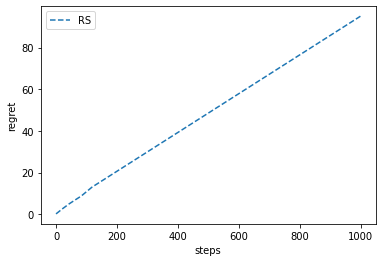

In [39]:
trial = 20
step = 1000      #step数が少ないと n(a_G)=n(a_j) になりaleph更新式がゼロ除算を行ってエラーになる
K = 2
sim = Simulator(trial, step, K)
sim.run()

In [ ]:
a = np.array([1,4,7,2,5])
print(np.where(a == 2))
print(np.amax(a))

In [ ]:
a = np.arange(10)
random.choice(a)

In [ ]:
K = 20
arm_prob = np.array([np.random.rand() for _ in range(K)])
arm_prob

In [ ]:
sys.float_info.min + 1